In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.feature_selection import VarianceThreshold,mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
class Preprocess:
    def __init__(self,train_file_path,test_file_path):
        self.test_df = pd.read_csv('testing-set.csv')
        self.train_df = pd.read_csv("training-set.csv")
        self.lb_ub={}
    def standardization(self,dataframe,col_name):
        mean_val = dataframe[col_name].mean()
        std_val = dataframe[col_name].std()
        dataframe[col_name]=((dataframe[col_name]-mean_val)/std_val)
    
    def remove_outlier(self,data_frame,column_name,isTest=False,verbose=0):
        if isTest:
            data_frame.loc[data_frame[column_name] > self.lb_ub[column_name][1] , column_name] = self.lb_ub[column_name][1]
            data_frame.loc[data_frame[column_name] < self.lb_ub[column_name][0] , column_name] = self.lb_ub[column_name][0]
            return
        l = data_frame[column_name].min()
        r = data_frame[column_name].max()
        q1 = data_frame[column_name].quantile(0.25)
        q3 = data_frame[column_name].quantile(0.75)
        iqr = q3 -q1
        lb = q1-3*iqr
        ub = q3+3*iqr

        num_outliers = data_frame[(data_frame[column_name]<lb) | (data_frame[column_name]>ub)].shape[0]

        data_frame.loc[data_frame[column_name] > ub , column_name] = ub
        data_frame.loc[data_frame[column_name] < lb , column_name] = lb
        self.lb_ub[column_name]=(lb,ub)
        if verbose == 1: 
            print("Min Value= ",l)
            print("Lower Bound = ",self.lb)
            print("Q1 = ",q1)
            print("Q2 = ",q3)
            print("Upper Bound = ", self.ub)
            print("Max Value = ",r)
            print("Number of Outliers = ",num_outliers)
            
    def get_correlated_features(self,correlation_matrix, threshold=0.8):
        num_features = correlation_matrix.shape[0]
        correlated_features = set()

        for i in range(num_features):
            for j in range(i + 1, num_features):
                correlation = correlation_matrix[i, j]
                if correlation >= threshold:
                    correlated_features.add((i,j))

        return correlated_features

    def train_set_preprocess(self):
        train_mal_df = self.train_df[self.train_df['label'] == 1]
        train_normal_df = self.train_df[self.train_df['label'] == 0]
        
        #outlier clipping 
        col = 'dur'
        self.remove_outlier(self.train_df,col)
        
        #max-value clipping
        self.cols_muls = {'spkts': 1.2, 'sloss': 1.2, 'dloss': 1.2}
        self.cols_maxvals = {}
        for col, multiplier in self.cols_muls.items():
            self.cols_maxvals[col] = train_normal_df[col].max()
            self.train_df.loc[self.train_df[col] > self.cols_maxvals[col], col] = (self.cols_maxvals[col] * multiplier)

        #clipping to 1
        self.columns_to_limit = ['is_ftp_login', 'ct_ftp_cmd']
        for col in self.columns_to_limit:
            self.train_df.loc[self.train_df[col] > 1, col] = 1
            
        #drop columns
        self.columns_to_drop = ['swin', 'stcpb', 'dtcpb', 'dwin', 'attack_cat']
        self.train_df = self.train_df.drop(columns=self.columns_to_drop, axis=1)
        
        #categical data handling
        col = 'proto'
        valid_protos = ['tcp', 'udp', 'arp', 'ospf', 'igmp', 'icmp', 'rtp']
        self.train_df[col] = self.train_df[col].apply(lambda x: x if x in valid_protos else 'm')

        valid_protos = ['igmp', 'icmp', 'rtp']
        self.train_df[col] = self.train_df[col].apply(lambda x: x if x not in valid_protos else 'n')
        
        self.train_df = pd.get_dummies(self.train_df, columns=[col], prefix='proto', drop_first=False)

        label_encoder = LabelEncoder()
        col = 'service'
        self.train_df[col] = label_encoder.fit_transform(self.train_df[col])
        
        col = 'state'
        temp = ['RST', 'ECO', 'PAR', 'URN', 'no']
        self.train_df[col] = self.train_df[col].apply(lambda x: x if x not in temp else 'm')
        self.train_df[col] = label_encoder.fit_transform(self.train_df[col])
        
        self.train_df = self.train_df.replace({True: 0, False: 1})
        
        #feature selection
        self.X_train = self.train_df.drop('label', axis=1)
        self.y_train = self.train_df['label']
        
        #remove constant features
        var_thres = VarianceThreshold(threshold = 0)
        var_thres.fit(self.X_train)
        self.dropable_const_cols = self.X_train.columns[[not col for col in var_thres.get_support()]]
        self.X_train = self.X_train.drop(self.dropable_const_cols,axis=1)
        
        #remove correlated features
        correlation_matrix = np.corrcoef(self.X_train, rowvar=False)
        self.correlated_features = [self.X_train.columns[x[0]] for x in self.get_correlated_features(correlation_matrix,0.95) ]
        self.X_train=self.X_train.drop(self.correlated_features,axis=1)
        
        #standardization
        for col in self.X_train.columns:
            self.standardization(self.X_train,col)

    def test_set_preprocess(self):
        test_mal_df = self.test_df[self.test_df['label'] == 1]
        test_normal_df = self.test_df[self.test_df['label'] == 0]
        
        #outlier clipping 
        col = 'dur'
        self.remove_outlier(self.test_df,col,True)
        
        #max-value clipping
        for col, multiplier in self.cols_muls.items():
            self.test_df.loc[self.test_df[col] > self.cols_maxvals[col], col] = (self.cols_maxvals[col] * multiplier)

        #clipping to 1
        for col in self.columns_to_limit:
            self.test_df.loc[self.test_df[col] > 1, col] = 1
            
        #drop columns
        self.test_df = self.test_df.drop(columns=self.columns_to_drop, axis=1)
        
        #categical data handling
        col = 'proto'
        valid_protos = ['tcp', 'udp', 'arp', 'ospf', 'igmp', 'icmp', 'rtp']
        self.test_df[col] = self.test_df[col].apply(lambda x: x if x in valid_protos else 'm')

        valid_protos = ['igmp', 'icmp', 'rtp']
        self.test_df[col] = self.test_df[col].apply(lambda x: x if x not in valid_protos else 'n')
        
        #one hot encoding
        self.test_df = pd.get_dummies(self.test_df, columns=[col], prefix='proto', drop_first=False)

        label_encoder = LabelEncoder()
        col = 'service'
        self.test_df[col] = label_encoder.fit_transform(self.test_df[col])
        
        col = 'state'
        temp = ['RST', 'ECO', 'PAR', 'URN', 'no']
        self.test_df[col] = self.test_df[col].apply(lambda x: x if x not in temp else 'm')
        self.test_df[col] = label_encoder.fit_transform(self.test_df[col])
        
        self.test_df = self.test_df.replace({True: 0, False: 1})
        
        #feature selection
        self.X_test = self.test_df.drop('label', axis=1)
        self.y_test = self.test_df['label']
        
        #remove constant features
        self.X_test = self.X_test.drop(self.dropable_const_cols,axis=1)
        
        #remove correlated features
        self.X_test=self.X_test.drop(self.correlated_features,axis=1)
        
        #standardization
        for col in self.X_test.columns:
            self.standardization(self.X_test,col)

In [3]:
test_file_path = pd.read_csv('testing-set.csv')
train_file_path = pd.read_csv("training-set.csv")

In [4]:
processed = Preprocess(train_file_path,test_file_path)
processed.train_set_preprocess()
processed.test_set_preprocess()

C:\Users\AR Computers\AppData\Local\Temp\ipykernel_2032\3953059108.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '158.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.train_df.loc[self.train_df[col] > self.cols_maxvals[col], col] = (self.cols_maxvals[col] * multiplier)
C:\Users\AR Computers\AppData\Local\Temp\ipykernel_2032\3953059108.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '856.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.train_df.loc[self.train_df[col] > self.cols_maxvals[col], col] = (self.cols_maxvals[col] * multiplier)
C:\Users\AR Computers\AppData\Local\Temp\ipykernel_2032\3953059108.py:124: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '158.4' has dtyp

In [5]:
X_train = processed.X_train
y_train = processed.y_train

X_test = processed.X_test
y_test = processed.y_test

In [6]:
X_test.columns

Index(['Unnamed: 0', 'dur', 'service', 'state', 'spkts', 'sbytes', 'dbytes',
       'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit',
       'djit', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports', 'proto_arp',
       'proto_m', 'proto_n', 'proto_ospf', 'proto_tcp', 'proto_udp'],
      dtype='object')

In [7]:
X_train.columns

Index(['Unnamed: 0', 'dur', 'service', 'state', 'spkts', 'sbytes', 'dbytes',
       'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit',
       'djit', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports', 'proto_arp',
       'proto_m', 'proto_n', 'proto_ospf', 'proto_tcp', 'proto_udp'],
      dtype='object')

In [8]:
X_test.to_csv('dt.csv')

# Random Forest Classifier

In [9]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier on the training data
history = rf_classifier.fit(X_train, y_train)

In [10]:
from sklearn.metrics import accuracy_score,classification_report
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37000
           1       1.00      1.00      1.00      4089

    accuracy                           1.00     41089
   macro avg       1.00      1.00      1.00     41089
weighted avg       1.00      1.00      1.00     41089



In [ ]:
import pickle
pickle.dump(RFC, open('model.pkl', 'wb'))
RFC = pickle.load(open("model.pkl","rb"))

# Decision Tree Classifier

In [11]:
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

DecisionTreeClassifier()

In [12]:
from sklearn.metrics import accuracy_score,classification_report
# Make predictions on the test set
y_pred = DT.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37000
           1       1.00      1.00      1.00      4089

    accuracy                           1.00     41089
   macro avg       1.00      1.00      1.00     41089
weighted avg       1.00      1.00      1.00     41089



# Gradient Boost Classifier

In [15]:
GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [16]:
# Make predictions on the test set
y_pred = GBC.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37000
           1       1.00      1.00      1.00      4089

    accuracy                           1.00     41089
   macro avg       1.00      1.00      1.00     41089
weighted avg       1.00      1.00      1.00     41089



In [17]:
import pickle
pickle.dump(GBC, open('model.pkl', 'wb'))
GBC = pickle.load(open("model.pkl","rb"))

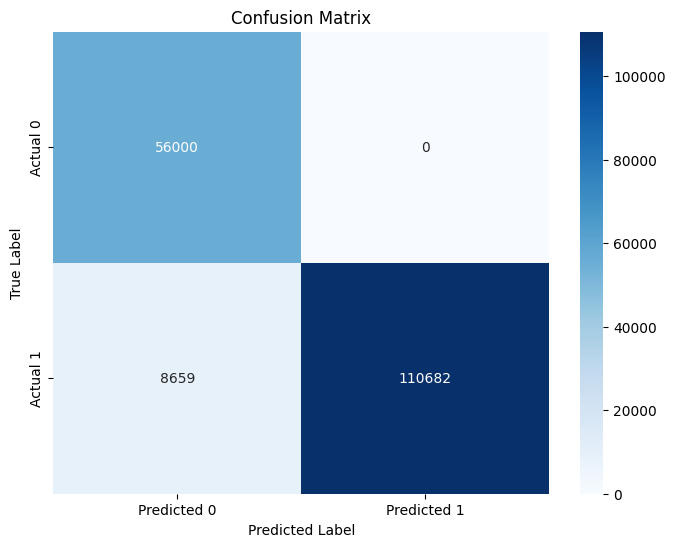

C:\Users\AR Computers\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\AR Computers\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\AR Computers\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\AR Computers\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.uni

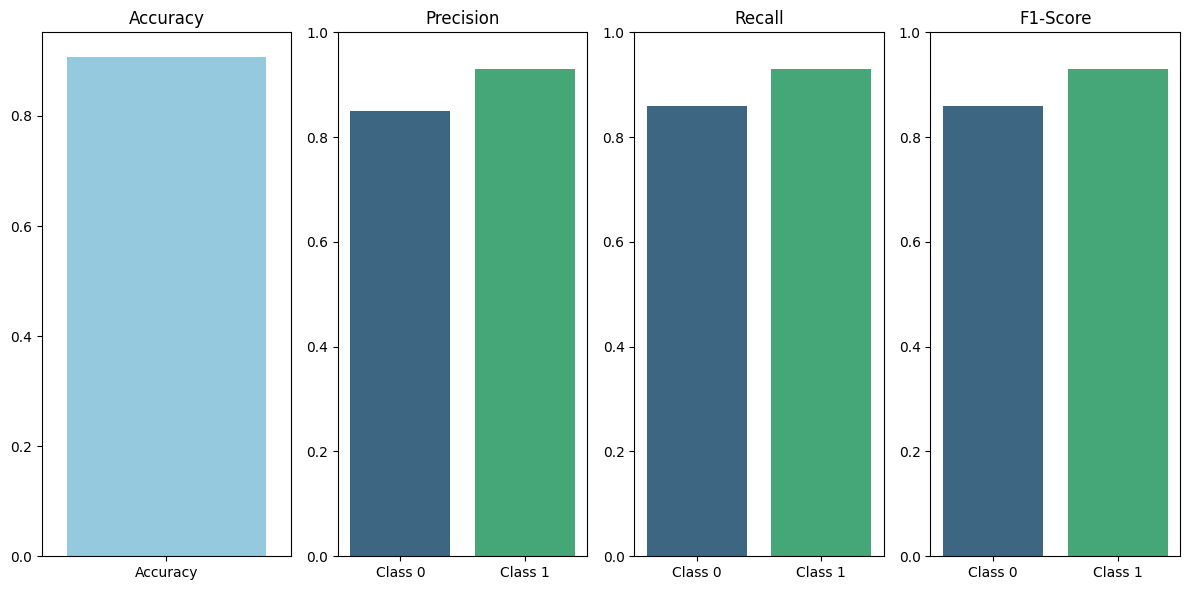

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Your classification report values
accuracy = 0.9066
precision = [0.85, 0.93]
recall = [0.86, 0.93]
f1_score = [0.86, 0.93]

# Confusion matrix values
true_negative, false_positive, false_negative, true_positive = 56000, 0, 8659, 110682
conf_matrix = [[true_negative, false_positive], [false_negative, true_positive]]

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plotting accuracy, precision, recall, and f1-score
labels = ['Accuracy', 'Class 0', 'Class 1']
metrics_values = [accuracy, precision, recall, f1_score]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

plt.figure(figsize=(12, 6))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    if i == 0:
        sns.barplot(x=[labels[i]], y=[metrics_values[i]], color='skyblue')
    else:
        sns.barplot(x=labels[1:], y=metrics_values[i], palette='viridis')
        plt.ylim([0, 1])
    plt.title(metrics_names[i])

plt.tight_layout()
plt.show()


In [23]:
df = pd.read_csv("dt.csv")

In [24]:
df.head()

,Unnamed: 0.1,Unnamed: 0,dur,service,state,spkts,sbytes,dbytes,rate,sload,...,ct_dst_sport_ltm,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,proto_arp,proto_m,proto_n,proto_ospf,proto_tcp,proto_udp
0,0,-2.065563,-0.685821,-0.503305,1.265872,-0.394404,-0.047338,-0.100937,0.462523,0.685626,...,-0.2662,-0.095971,-0.221396,-0.150999,0.156881,0.262403,0.02703,0.079179,1.540053,-1.992674
1,1,-2.065520,-0.685825,-0.503305,1.265872,-0.394404,-0.036080,-0.100937,0.763155,4.292987,...,-0.2662,-0.095971,-0.221396,-0.150999,0.156881,0.262403,0.02703,0.079179,1.540053,-1.992674
2,2,-2.065477,-0.685828,-0.503305,1.265872,-0.394404,-0.042251,-0.100937,1.424545,4.156032,...,-0.2662,-0.095971,-0.221396,-0.150999,0.156881,0.262403,0.02703,0.079179,1.540053,-1.992674
3,3,-2.065434,-0.685827,-0.503305,1.265872,-0.394404,-0.043745,-0.100937,1.130594,2.846205,...,-0.2662,-0.095971,-0.221396,-0.150999,0.156881,0.262403,0.02703,0.079179,1.540053,-1.992674
4,4,-2.065391,-0.685822,-0.503305,1.265872,-0.394404,-0.032843,-0.100937,0.542692,4.135437,...,-0.2662,-0.095971,-0.221396,-0.150999,0.156881,0.262403,0.02703,0.079179,1.540053,-1.992674


In [28]:
df = df.drop(['Unnamed: 0.1'], axis=1)
df.head(4)

,dur,service,state,spkts,sbytes,dbytes,rate,sload,dload,sloss,...,ct_dst_sport_ltm,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,proto_arp,proto_m,proto_n,proto_ospf,proto_tcp,proto_udp
0,-0.685821,-0.503305,1.265872,-0.394404,-0.047338,-0.100937,0.462523,0.685626,-0.378542,-0.447174,...,-0.2662,-0.095971,-0.221396,-0.150999,0.156881,0.262403,0.02703,0.079179,1.540053,-1.992674
1,-0.685825,-0.503305,1.265872,-0.394404,-0.036080,-0.100937,0.763155,4.292987,-0.378542,-0.447174,...,-0.2662,-0.095971,-0.221396,-0.150999,0.156881,0.262403,0.02703,0.079179,1.540053,-1.992674
2,-0.685828,-0.503305,1.265872,-0.394404,-0.042251,-0.100937,1.424545,4.156032,-0.378542,-0.447174,...,-0.2662,-0.095971,-0.221396,-0.150999,0.156881,0.262403,0.02703,0.079179,1.540053,-1.992674
3,-0.685827,-0.503305,1.265872,-0.394404,-0.043745,-0.100937,1.130594,2.846205,-0.378542,-0.447174,...,-0.2662,-0.095971,-0.221396,-0.150999,0.156881,0.262403,0.02703,0.079179,1.540053,-1.992674


In [29]:
df.to_csv('dta.csv')